In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
import pandas as pd
from collections import defaultdict, OrderedDict
from tqdm import tqdm
import pickle
from scipy.stats import pearsonr

sns.set_style('whitegrid')

## Correlation between Traditional and Pairwise DESeq2 over a Range of Partitions and the Number of Results Combined

### Runtime per Number of Results to Combine

Pairwise DESeq2 produces separate results for each group, which are then combined. The combination is a negligible cost, as the runtime per result file drops exponentionally to ~1s per result, but it costs additional core hours per 

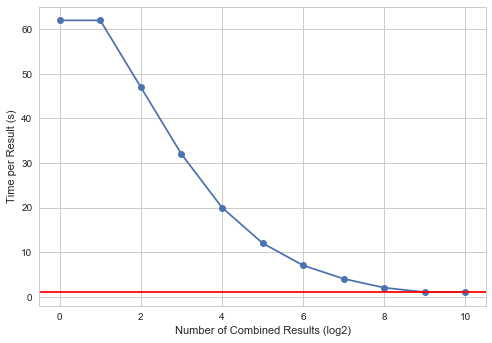

In [31]:
samples = [2**i for i in xrange(11)]
times = [62, 125, 191, 257, 325, 397, 477, 570, 693, 883, 1178]
rate = np.array(times) / samples
plt.plot(np.log2(samples), rate, marker='o')
plt.axhline(1, c='r')
plt.xlabel('Number of Combined Results (log2)')
plt.ylabel('Time per Result (s)');

### Correlation Plot

In [19]:
def rank(ref_genes, genes_to_rank):
    temp = {}
    ranks = []
    inter = set(ref_genes).intersection(set(genes_to_rank))
    ref_genes = [x for x in ref_genes if x in inter]
    genes_to_rank = [x for x in genes_to_rank if x in inter]
    # print 'Length of intersection: {}'.format(len(inter))
    for i, gene in enumerate(ref_genes):
        temp[gene] = i
    for gene in genes_to_rank:
        ranks.append(temp[gene])
    return ranks

Read in traditional results for breast tissue

In [32]:
data = '../../data/partition-pearson/'
np_breast = pd.read_csv('../../data/TvN/breast.tsv', sep='\t', index_col=0)

Read in results across partition sizes

In [40]:
partitions = {int(x): {} for x in os.listdir(data) if os.path.isdir(os.path.join(data, x))}
for i in partitions.keys():
    partitions[i] = {int(x.split('-')[-1][:-4]): pd.read_csv(os.path.join(data, str(i), x), sep='\t', index_col=0) 
                     for x in os.listdir(os.path.join(data, str(i)))}

Calculate pearsonR of gene ranks and plot as function of the number of pairwise results were combined

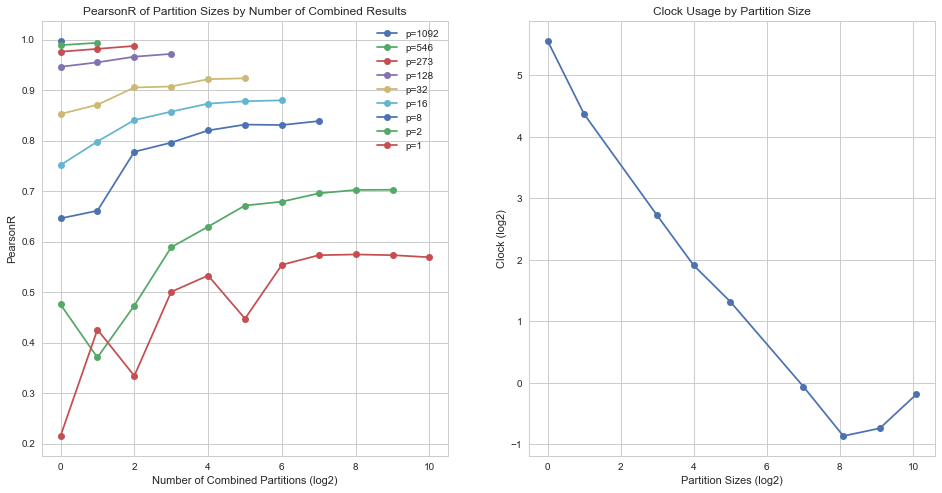

In [58]:
f, ax = plt.subplots(1, 2, figsize=(16, 8))
for p in sorted(partitions.keys(), reverse=True):
    ps = []
    for n in sorted(partitions[p]):
        r = rank(np_breast.geneId, partitions[p][n].index)
        ps.append(pearsonr(np.array([x for x in xrange(len(r))]), np.array(r))[0])
    ax[0].plot(np.log2(sorted(partitions[p].keys())), ps, marker='o', label='p=' + str(p))
ax[0].set_xlabel('Number of Combined Partitions (log2)')
ax[0].set_ylabel('PearsonR')
ax[0].set_title('PearsonR of Partition Sizes by Number of Combined Results')
ax[0].legend()

ps = [1, 2, 8, 16, 32, 128, 273, 546, 1092]
clocks = [47.3, 20.7, 6.6, 3.76, 2.5, 0.96, 0.55, 0.6, 0.88]
ax[1].plot(np.log2(ps), np.log2(clocks), marker='o')
ax[1].set_xlabel('Partition Sizes (log2)')
ax[1].set_ylabel('Clock (log2)')
ax[1].set_title('Clock Usage by Partition Size');

Total runtime is also an important factor, as DESeq2 can only be run using multiple cores using another R package, and can't be run distributed over more than one machine.

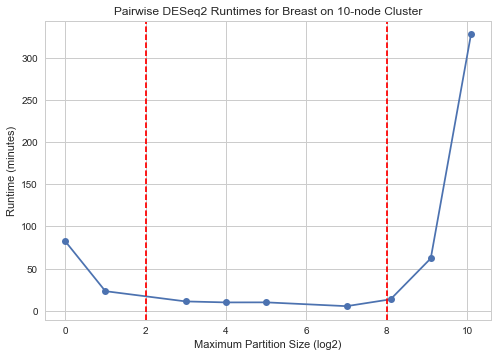

In [59]:
runtimes = [57.5121666667 + 25, 23.1938333333, 11.0256666667, 9.853, 9.925, 5.40283333333, 13.5255, 62.0955, 327.7685]
plt.plot(np.log2(ps), runtimes, marker='o')
plt.axvline(2, ls='--', c='r')
plt.axvline(8, ls='--', c='r')
plt.ylabel('Runtime (minutes)')
plt.xlabel('Maximum Partition Size (log2)')
plt.title('Pairwise DESeq2 Runtimes for Breast on 10-node Cluster');

A partition size of 128 in this setting 